In [2]:
import os
import matplotlib.pyplot as plt
import argparse
import numpy as np

from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Input, Embedding, LSTM, Dense, Conv2D, Flatten, Reshape, Add, Concatenate, MaxPool2D
from keras.models import Model, Sequential, load_model
from keras.optimizers import Adam
from keras import backend as K

from model.unet import unet, unet_small, dice_coef, normalized_iou_coef, hard_normalized_hard_iou_coef
from model.fcn import fcn_8s
from model.pspnet import pspnet50
from dataset_parser import generator_miscl, generator

from scripts import *

import random

%load_ext autoreload
%autoreload 2

print('GPUs available:', K.tensorflow_backend._get_available_gpus())

CLEAN_N = 100
TRAIN_N = 2975
VAL_N = 500

/usr/lib/python3/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.






GPUs available: ['/job:localhost/replica:0/task:0/device:GPU:0']


# Clean Model

In [ ]:
# TRAIN_BATCH = int(4)
# VAL_BATCH = int(4)
# lr_init = 1e-4
# lr_decay = 5e-4
# vgg_path = None
# TRAIN_N = 2975
# VAL_N = 500

# model_name = "modular_unet_clean_benchmark_other_metrics.h5"

# labels = ['background', 'car', 'road']  # Use only 3 classes.
# ignore_pedestrians=not('person' in labels)

# clean_model = unet(input_shape=(256, 512, 3), num_classes=len(labels),
#                     lr_init=lr_init, lr_decay=lr_decay, vgg_weight_path=vgg_path)

In [3]:
# checkpoint = ModelCheckpoint(filepath=model_name,
#                              monitor='val_dice_coef',
#                              mode='max',
#                              save_best_only=True,
#                              save_weights_only=True)

In [4]:
# history = clean_model.fit_generator(generator.data_generator('dataset_parser/data.h5', TRAIN_BATCH, 'train', ignore_pedestrians=ignore_pedestrians),
#                                     steps_per_epoch= TRAIN_N // TRAIN_BATCH,
#                                     validation_data=generator.data_generator('dataset_parser/data.h5', VAL_BATCH, 'val', ignore_pedestrians=ignore_pedestrians),
#                                     validation_steps= VAL_N // VAL_BATCH,
#                                     callbacks=[checkpoint],
#                                     epochs=5, verbose=1)

In [5]:
# clean_model.load_weights(model_name)

# Just Gold Data

In [6]:
TRAIN_BATCH = int(4)
VAL_BATCH = int(4)
lr_init = 1e-4
lr_decay = 5e-4
vgg_path = None
TRAIN_N = 2975
VAL_N = 500

model_name = "modular_unet_gold_benchmark_other_metrics.h5"

labels = ['background', 'car', 'road']  # Use only 3 classes.
ignore_pedestrians=not('person' in labels)

gold_model = unet(input_shape=(256, 512, 3), num_classes=len(labels),
                    lr_init=lr_init, lr_decay=lr_decay, vgg_weight_path=vgg_path)









Instructions for updating:
Use tf.print instead of tf.Print. Note that tf.print returns a no-output operator that directly prints the output. Outside of defuns or eager mode, this operator will not be executed unless it is directly specified in session.run or used as a control dependency for other operators. This is only a concern in graph mode. Below is an example of how to ensure tf.print executes in graph mode:



In [7]:
checkpoint = ModelCheckpoint(filepath=model_name,
                             monitor='val_dice_coef',
                             mode='max',
                             save_best_only=True,
                             save_weights_only=True)

In [8]:
fine_generator = generator.data_generator('dataset_parser/data.h5', TRAIN_BATCH, 'train', ignore_pedestrians=ignore_pedestrians)

history = gold_model.fit_generator(fine_generator,
                                   steps_per_epoch= CLEAN_N // TRAIN_BATCH,
                                   validation_data=generator.data_generator('dataset_parser/data.h5', VAL_BATCH, 'val', ignore_pedestrians=ignore_pedestrians),
                                   validation_steps= VAL_N // VAL_BATCH,
                                   callbacks=[checkpoint],
                                   epochs=5, verbose=1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/5
500
500
2975
2975


62/62 [==============================] - 40s 651ms/step - loss: 0.5151 - dice_coef: 0.6973 - normalized_iou_coef: 0.4004 - hard_normalized_hard_iou_coef: 0.4694 - val_loss: 1.0172 - val_dice_coef: 0.7453 - val_normalized_iou_coef: 0.3808 - val_hard_normalized_hard_iou_coef: 0.3864
Epoch 2/5
62/62 [==============================] - 32s 516ms/step - loss: 0.3478 - dice_coef: 0.7966 - normalized_iou_coef: 0.4979 - hard_normalized_hard_iou_coef: 0.5632 - val_loss: 0.5180 - val_dice_coef: 0.7641 - val_normalized_iou_coef: 0.4744 - val_hard_normalized_hard_iou_coef: 0.5102
Epoch 3/5
62/62 [==============================] - 32s 518ms/step - loss: 0.3485 - dice_coef: 0.7983 - normalized_iou_coef: 0.5002 - hard_normalized_hard_iou_coef: 0.5843 - val_loss: 0.6039 - val_dice_coef: 0.7853 - val_normalized_iou_coef: 0.5083 - val_hard_normalized_hard_iou_coef: 0.5579
Epoch 4/

# Pseudolabeling

In [9]:
TRAIN_BATCH = int(4)
VAL_BATCH = int(4)
lr_init = 1e-4
lr_decay = 5e-4
vgg_path = None

model_name = "modular_unet_pseu_benchmark_other_metrics.h5"

labels = ['background', 'car', 'road']  # Use only 3 classes.
ignore_pedestrians=not('person' in labels)

pseu_model = unet(input_shape=(256, 512, 3), num_classes=len(labels),
                    lr_init=lr_init, lr_decay=lr_decay, vgg_weight_path=vgg_path)

In [10]:
checkpoint = ModelCheckpoint(filepath=model_name,
                             monitor='val_dice_coef',
                             mode='max',
                             save_best_only=True,
                             save_weights_only=True)

In [11]:
n_epochs = 3

for e in range(n_epochs):
    coarse_generator = generator_coarse.data_generator('dataset_parser/data-coarse.h5', TRAIN_BATCH, 
                                                       'train_extra', ignore_pedestrians=ignore_pedestrians)
    for i in range(TRAIN_N // TRAIN_BATCH):
        x, _ = next(coarse_generator)
        y_pred = gold_model.predict(x)
        metrics = pseu_model.train_on_batch(x, y_pred)  # x and y
        print(i, metrics)
    
#     metrics = ec_model.evaluate(y_val_coarse_batch, y_val_diff_batch)  # y only
    metrics = pseu_model.evaluate_generator(generator.data_generator('dataset_parser/data.h5', VAL_BATCH, 'val', ignore_pedestrians=ignore_pedestrians),
                              steps=VAL_N // VAL_BATCH)  # x and y 
    print('\nEpoch {}, batch {}, Validation metrics (loss, dice_coef, iou, hard_iou): {}'.format(e, i, metrics))

5000
0 [1.3098178, 0.32024664, 0.15761715, 0.15117978521008824]
1 [1.1648134, 0.35047054, 0.17935038, 0.20172492681153031]
2 [1.0762477, 0.3794311, 0.20256111, 0.25329008473748577]
3 [0.97731495, 0.4162627, 0.21724336, 0.2896765264906562]
4 [0.91634655, 0.44383234, 0.22822079, 0.31857495426542914]
5 [0.86229026, 0.47259146, 0.247581, 0.3466001885510108]
6 [0.82519174, 0.49502563, 0.26271296, 0.3632516026498099]
7 [0.7282883, 0.5386989, 0.29889488, 0.43698824116949037]
8 [0.61005807, 0.597198, 0.3409526, 0.5094054577832514]
9 [0.64008, 0.5894855, 0.34212536, 0.4747271460574907]
10 [0.6052629, 0.61227816, 0.3578512, 0.5040842505352501]
11 [0.6496842, 0.5959995, 0.33054715, 0.44041426089223235]
12 [0.57678664, 0.63488114, 0.3750698, 0.49260791518591984]
13 [0.58704185, 0.6332866, 0.35373968, 0.47504104871028785]
14 [0.50665325, 0.6683582, 0.38563848, 0.5182969756087044]
15 [0.52464676, 0.6652258, 0.39474282, 0.5299009886244654]
16 [0.46686822, 0.69085455, 0.4052562, 0.5540557534142221]
17

# Coarse Data

In [12]:
TRAIN_BATCH = int(4)
VAL_BATCH = int(4)
lr_init = 1e-4
lr_decay = 5e-4
vgg_path = None
TRAIN_N = 2975
VAL_N = 500

model_name = "modular_unet_coarse_benchmark_other_metrics.h5"

labels = ['background', 'car', 'road']  # Use only 3 classes.
ignore_pedestrians=not('person' in labels)

coarse_model = unet(input_shape=(256, 512, 3), num_classes=len(labels),
                    lr_init=lr_init, lr_decay=lr_decay, vgg_weight_path=vgg_path)

In [13]:
# checkpoint = ModelCheckpoint(filepath=model_name,
#                              monitor='val_dice_coef',
#                              mode='max',                             
#                              save_best_only=True,
#                              save_weights_only=True)

In [14]:
# history = coarse_model.fit_generator(generator_coarse.data_generator('dataset_parser/data-coarse.h5', TRAIN_BATCH, 'train_extra', ignore_pedestrians=ignore_pedestrians),
#                                      steps_per_epoch= TRAIN_N // TRAIN_BATCH,
#                                      validation_data=generator.data_generator('dataset_parser/data.h5', VAL_BATCH, 'val', ignore_pedestrians=ignore_pedestrians),
#                                      validation_steps=VAL_N // VAL_BATCH,
#                                      callbacks=[checkpoint],
#                                      epochs=5, verbose=1)

In [15]:
coarse_model.load_weights(model_name)

# Apply Error Correction Networks (Full)

In [16]:
from keras.layers import Input, Embedding, LSTM, Dense, Conv2D, Flatten, Reshape, Add, Concatenate, MaxPool2D, Lambda
from keras.models import Model, Sequential, load_model
from keras.optimizers import Adam
from keras import backend as K

input_window_size = 64
output_window_size = 1

# ec_model = get_ec_model(input_window_size, output_window_size, dice_coef=dice_coef)

lr_init = 1e-3
lr_decay = 5e-4

inp_y = Input(shape=(input_window_size, input_window_size, 3))
inp_x = Input(shape=(input_window_size, input_window_size, 3))

h = Concatenate()([inp_x, inp_y])
h = Conv2D(8, (4, 4), padding='same', activation='relu')(h)
h = MaxPool2D((2, 2), padding='same')(h)
h = Conv2D(8, (4, 4), padding='same', activation='relu')(h)
h = MaxPool2D((2, 2), padding='same')(h)
h = Conv2D(16, (4, 4), padding='same', activation='relu')(h)
h = Flatten()(h)
h = Dense(40, activation='relu')(h)
h = Dense(3, activation='softmax')(h)
h = Reshape((1, 1, 3))(h)
ec_model = Model(inputs=[inp_x, inp_y], outputs=h)

ec_model.summary()
metrics=[dice_coef, normalized_iou_coef, hard_normalized_hard_iou_coef]
ec_model.compile(optimizer=Adam(lr=lr_init, decay=lr_decay),
                 loss='categorical_crossentropy', metrics=metrics)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
concatenate_13 (Concatenate)    (None, 64, 64, 6)    0           input_5[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_28 (Conv2D)              (None, 64, 64, 8)    776         concatenate_13[0][0]             
__________

In [17]:
n_epochs = 3
batch_size = 8
skip = 12
N_CLEAN = 500
best_val = 0

val_generator = generator.data_generator('dataset_parser/data.h5', 32, 'val', ignore_pedestrians=True)

x_val, y_val = next(val_generator)
y_val_coarse = coarse_model.predict(x_val)
x_val_batch, y_val_coarse_batch, y_val_diff_batch = get_ec_batch(
    x_val, y_val, y_val_coarse, input_window_size=input_window_size,
    output_window_size=output_window_size, skip=skip, diff=False)

for e in range(n_epochs):
    fine_generator = generator.data_generator('dataset_parser/data.h5', batch_size, 'train', 
                                              ignore_pedestrians=ignore_pedestrians)
    for i in range(N_CLEAN // batch_size):
        x, y_fine = next(fine_generator)
        y_coarse = coarse_model.predict(x)
        x_batch, y_coarse_batch, y_diff_batch = get_ec_batch(x, y_fine, y_coarse, input_window_size=input_window_size,
                                                             output_window_size=output_window_size, skip=skip, diff=False,
                                                             balanced=True)
        
#         metrics = ec_model.train_on_batch(y_coarse_batch, y_diff_batch)
        metrics = ec_model.train_on_batch([x_batch, y_coarse_batch], y_diff_batch)  # x and y
        print(i, metrics)
    
#     metrics = ec_model.evaluate(y_val_coarse_batch, y_val_diff_batch)  # y only
    metrics = ec_model.evaluate([x_val_batch, y_val_coarse_batch], y_val_diff_batch)  # x and y 
    print('\nEpoch {}, batch {}, Validation metrics (loss, dice_coef, iou, hard_iou): {}'.format(e, i, metrics))
    if metrics[-1] > best_val:
        best_val = metrics[-1]
        ec_model.save('best-ec-model-5.h5')
        print('Model saved')

500
500
2975
2975
0 [1.0703595, 0.34371606, 0.19609144, 0.2677398644488479]
1 [0.95356536, 0.4216513, 0.22423267, 0.14320297951582867]
2 [0.89503485, 0.4571709, 0.26065361, 0.45842203662763714]
3 [0.6520767, 0.543935, 0.29033506, 0.48230602742022755]
4 [0.6777152, 0.57542753, 0.33920002, 0.4410573950038994]
5 [0.63499117, 0.61792624, 0.36914152, 0.43263933732366233]
6 [0.55870366, 0.69818544, 0.3996269, 0.4437246846569154]
7 [0.5213819, 0.7001015, 0.4231056, 0.4621528245165343]
8 [0.75511134, 0.6413638, 0.4149352, 0.41952822387604993]
9 [0.6931598, 0.63741124, 0.42358553, 0.4346567930159262]
10 [0.536807, 0.6899354, 0.45741516, 0.47494059657853543]
11 [0.5987759, 0.6653121, 0.41860902, 0.4611923218899963]
12 [0.64295894, 0.648607, 0.41359586, 0.4321211650206843]
13 [0.7901836, 0.6115918, 0.40117714, 0.42905465159839473]
14 [0.57043654, 0.6540899, 0.41625953, 0.46912299370399924]
15 [0.63164335, 0.64792955, 0.38671717, 0.47515028363390055]
16 [0.63324744, 0.60884744, 0.38894057, 0.45484

In [18]:
y_p = ec_model.predict([x_val_batch, y_val_coarse_batch])

In [19]:
np_hard_normalized_hard_iou_coef(y_val_diff_batch, y_p)

0.7407374815238001

# Apply Error Correction Networks (Y only)

In [20]:
def get_ec_model():
    input_window_size = 64
    output_window_size = 1

    # ec_model = get_ec_model(input_window_size, output_window_size, dice_coef=dice_coef)

    lr_init = 1e-3
    lr_decay = 5e-4

    inp_y = Input(shape=(input_window_size, input_window_size, 3))
    inp_x = Input(shape=(input_window_size, input_window_size, 3))

    h = Concatenate()([inp_x, inp_y])
    h = Conv2D(8, (4, 4), padding='same', activation='relu')(h)
    h = MaxPool2D((2, 2), padding='same')(h)
    h = Conv2D(8, (4, 4), padding='same', activation='relu')(h)
    h = MaxPool2D((2, 2), padding='same')(h)
    h = Conv2D(16, (4, 4), padding='same', activation='relu')(h)
    h = Flatten()(h)
    h = Dense(40, activation='relu')(h)
    h = Dense(3, activation='softmax')(h)
    h = Reshape((1, 1, 3))(h)
    ec_model = Model(inputs=[inp_x, inp_y], outputs=h)

    ec_model.summary()
    metrics=[dice_coef, normalized_iou_coef, hard_normalized_hard_iou_coef]
    ec_model.compile(optimizer=Adam(lr=lr_init, decay=lr_decay),
                     loss='categorical_crossentropy', metrics=metrics) 
    return ec_model

In [21]:
ec_model = get_ec_model()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
concatenate_14 (Concatenate)    (None, 64, 64, 6)    0           input_7[0][0]                    
                                                                 input_6[0][0]                    
__________________________________________________________________________________________________
conv2d_31 (Conv2D)              (None, 64, 64, 8)    776         concatenate_14[0][0]             
__________

In [22]:
n_epochs = 3
batch_size = 8
skip = 12
N_CLEAN = 500
best_val = 0

val_generator = generator.data_generator('dataset_parser/data.h5', 32, 'val', ignore_pedestrians=True)

x_val, y_val = next(val_generator)
y_val_coarse = coarse_model.predict(x_val)
x_val_batch, y_val_coarse_batch, y_val_diff_batch = get_ec_batch(
    x_val, y_val, y_val_coarse, input_window_size=input_window_size,
    output_window_size=output_window_size, skip=skip, diff=False)

for e in range(n_epochs):
    fine_generator = generator.data_generator('dataset_parser/data.h5', batch_size, 'train', 
                                              ignore_pedestrians=ignore_pedestrians)
    for i in range(N_CLEAN // batch_size):
        x, y_fine = next(fine_generator)
        y_coarse = coarse_model.predict(x)
        x_batch, y_coarse_batch, y_diff_batch = get_ec_batch(x, y_fine, y_coarse, input_window_size=input_window_size,
                                                             output_window_size=output_window_size, skip=skip, diff=False,
                                                             balanced=True)
        x_batch = np.random.random(x_batch.shape)
#         metrics = ec_model.train_on_batch(y_coarse_batch, y_diff_batch)
        metrics = ec_model.train_on_batch([x_batch, y_coarse_batch], y_diff_batch)  # x and y
        print(i, metrics)
    
#     metrics = ec_model.evaluate(y_val_coarse_batch, y_val_diff_batch)  # y only
    metrics = ec_model.evaluate([x_val_batch, y_val_coarse_batch], y_val_diff_batch)  # x and y 
    print('\nEpoch {}, batch {}, Validation metrics (loss, dice_coef, iou, hard_iou): {}'.format(e, i, metrics))
    if metrics[-1] > best_val:
        best_val = metrics[-1]
        ec_model.save('best-ec-model-5.h5')
        print('Model saved')

500
500
2975
2975
0 [1.061061, 0.34706408, 0.19936973, 0.36020978382735863]
1 [0.8694, 0.43584856, 0.24476185, 0.4353858219142122]
2 [0.77676785, 0.53398216, 0.3217908, 0.4369590049832337]
3 [0.52104735, 0.67481756, 0.38478106, 0.4558605501666831]
4 [0.6932383, 0.6908619, 0.4199663, 0.4448235913638757]
5 [0.63692933, 0.73271585, 0.44631502, 0.45767573184338506]
6 [0.56105715, 0.74388254, 0.449586, 0.44923469357319173]
7 [0.6072902, 0.7222955, 0.4410487, 0.4503962382032817]
8 [0.6722814, 0.652372, 0.43025827, 0.43748994414627884]
9 [0.6782472, 0.62533, 0.42026013, 0.47352143839545546]
10 [0.574916, 0.6424495, 0.43028092, 0.565253962421965]
11 [0.638804, 0.60050917, 0.38502616, 0.5474090745593294]
12 [0.6555246, 0.61244285, 0.39132008, 0.5239719911110643]
13 [0.7252228, 0.6324868, 0.4204015, 0.5983512898202241]
14 [0.50612116, 0.69458306, 0.44016862, 0.5273067457426267]
15 [0.5873849, 0.71692425, 0.42309707, 0.46928077213791497]
16 [0.5573281, 0.705183, 0.45031548, 0.5499565805224231]
17

In [23]:
y_p = ec_model.predict([x_val_batch, y_val_coarse_batch])

In [24]:
np_hard_normalized_hard_iou_coef(y_val_diff_batch, y_p)

0.6188357824122074

# Apply Error Correction Networks (Y only)

In [25]:
ec_model = get_ec_model()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
concatenate_15 (Concatenate)    (None, 64, 64, 6)    0           input_9[0][0]                    
                                                                 input_8[0][0]                    
__________________________________________________________________________________________________
conv2d_34 (Conv2D)              (None, 64, 64, 8)    776         concatenate_15[0][0]             
__________

In [26]:
n_epochs = 3
batch_size = 8
skip = 12
N_CLEAN = 500
best_val = 0

val_generator = generator.data_generator('dataset_parser/data.h5', 32, 'val', ignore_pedestrians=True)

x_val, y_val = next(val_generator)
y_val_coarse = coarse_model.predict(x_val)
x_val_batch, y_val_coarse_batch, y_val_diff_batch = get_ec_batch(
    x_val, y_val, y_val_coarse, input_window_size=input_window_size,
    output_window_size=output_window_size, skip=skip, diff=False)

for e in range(n_epochs):
    fine_generator = generator.data_generator('dataset_parser/data.h5', batch_size, 'train', 
                                              ignore_pedestrians=ignore_pedestrians)
    for i in range(N_CLEAN // batch_size):
        x, y_fine = next(fine_generator)
        y_coarse = coarse_model.predict(x)
        x_batch, y_coarse_batch, y_diff_batch = get_ec_batch(x, y_fine, y_coarse, input_window_size=input_window_size,
                                                             output_window_size=output_window_size, skip=skip, diff=False,
                                                             balanced=True)
        y_coarse_batch = np.random.random(y_coarse_batch.shape)
#         metrics = ec_model.train_on_batch(y_coarse_batch, y_diff_batch)
        metrics = ec_model.train_on_batch([x_batch, y_coarse_batch], y_diff_batch)  # x and y
        print(i, metrics)
    
#     metrics = ec_model.evaluate(y_val_coarse_batch, y_val_diff_batch)  # y only
    metrics = ec_model.evaluate([x_val_batch, y_val_coarse_batch], y_val_diff_batch)  # x and y 
    print('\nEpoch {}, batch {}, Validation metrics (loss, dice_coef, iou, hard_iou): {}'.format(e, i, metrics))
    if metrics[-1] > best_val:
        best_val = metrics[-1]
        ec_model.save('best-ec-model-5.h5')
        print('Model saved')

500
500
2975
2975
0 [1.1002563, 0.33433145, 0.19155219, 0.13224530802690576]
1 [1.0305287, 0.3687041, 0.19856349, 0.1506706285507995]
2 [1.0934105, 0.37931612, 0.20373933, 0.14486257945653852]
3 [0.94805837, 0.40578753, 0.2007359, 0.13115169964485032]
4 [0.9995937, 0.40014598, 0.21049222, 0.14896755162241887]
5 [0.9297342, 0.41518992, 0.21283214, 0.2176767676767677]
6 [0.88643783, 0.43088728, 0.21414486, 0.2526221314263413]
7 [0.9070652, 0.44781676, 0.21993074, 0.20851200162665898]
8 [1.1464436, 0.40977967, 0.2101216, 0.18399148500166743]
9 [1.1308134, 0.38414338, 0.20482425, 0.126890581137339]
10 [0.9606932, 0.41419837, 0.22702208, 0.26955113470138337]
11 [0.9351874, 0.40128887, 0.21577828, 0.30879335995615065]
12 [0.9710582, 0.38680452, 0.21298158, 0.23584369965401578]
13 [1.0211703, 0.37659428, 0.20720443, 0.19044164439353442]
14 [1.0177817, 0.38297603, 0.20278499, 0.17959326546899101]
15 [0.8969622, 0.42149624, 0.2147511, 0.3244008917254685]
16 [0.9063517, 0.42697367, 0.22609192, 0

In [27]:
y_p = ec_model.predict([x_val_batch, y_val_coarse_batch])

In [28]:
np_hard_normalized_hard_iou_coef(y_val_diff_batch, y_p)

0.1956045421001262

# Show Some Images

2975
2975
2975


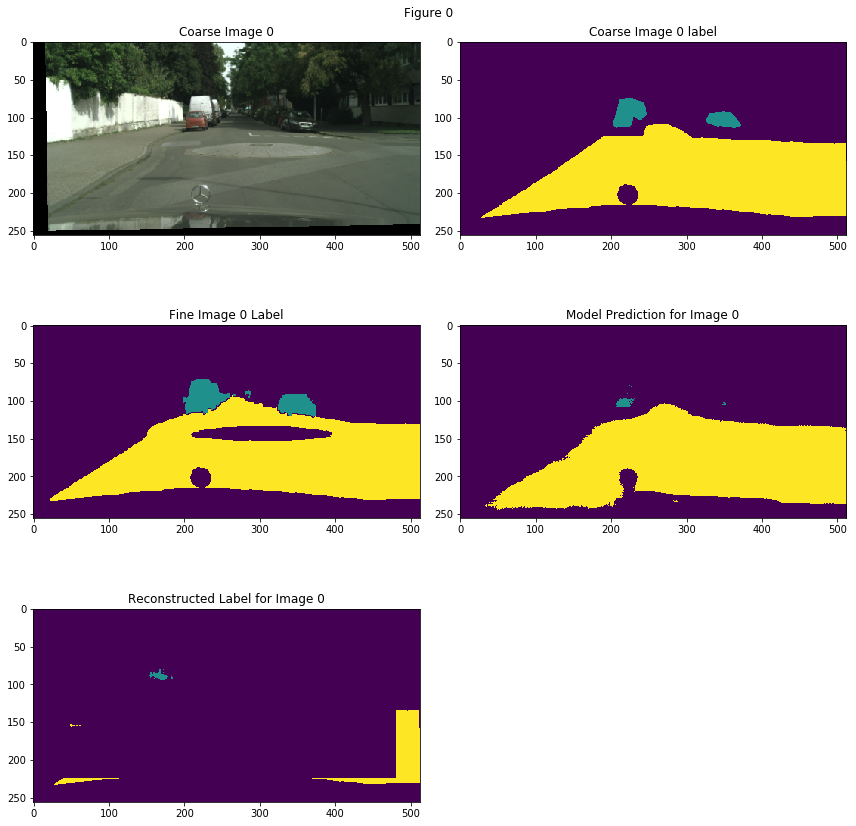

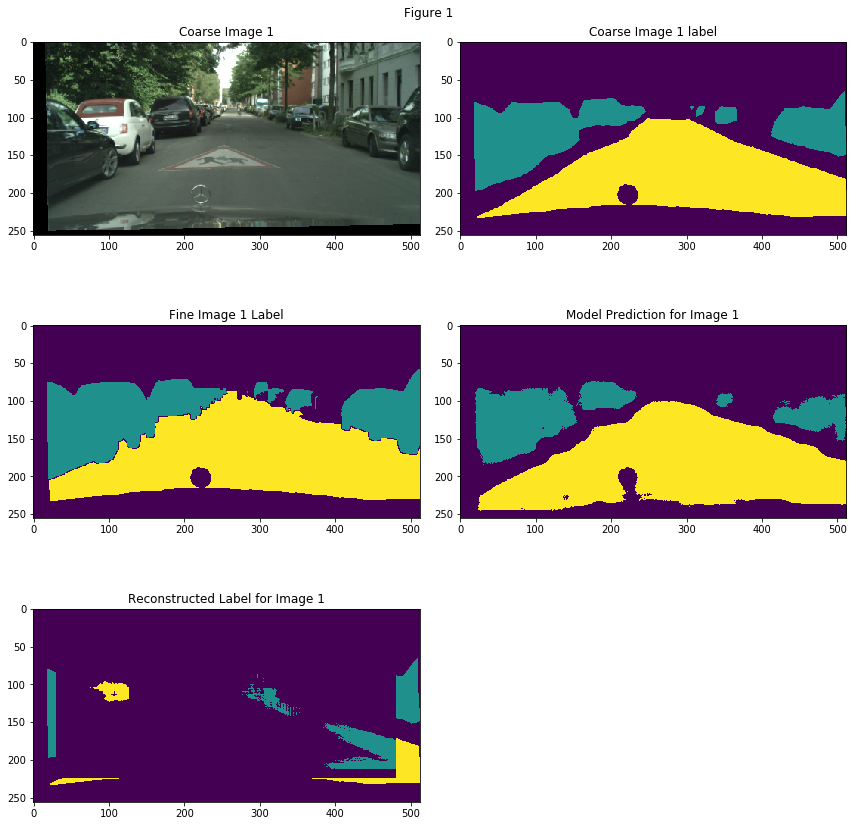

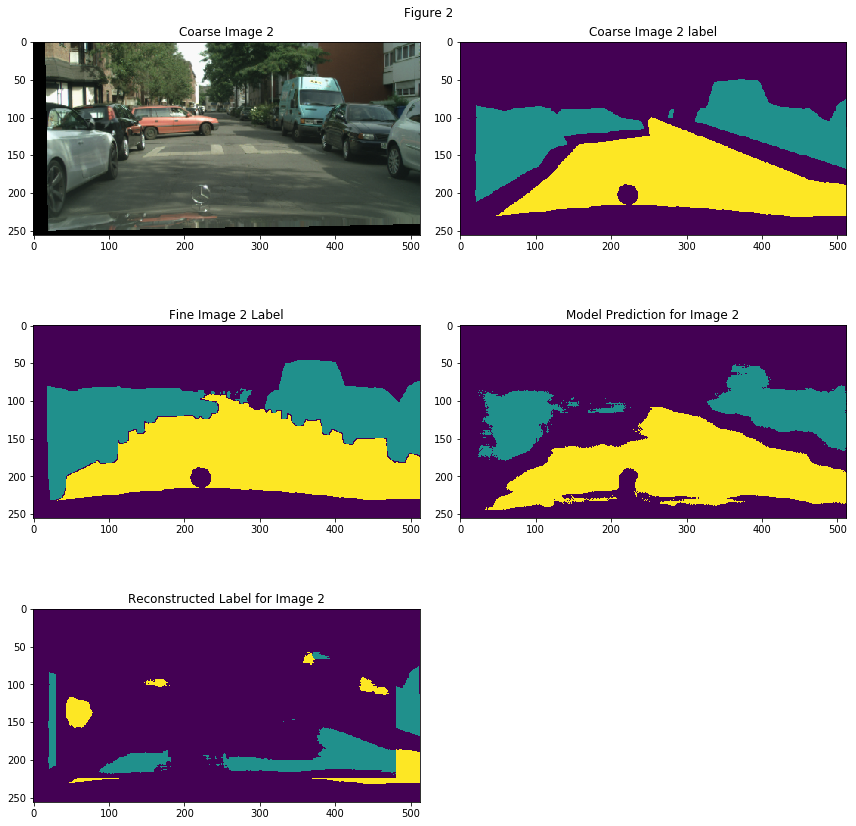

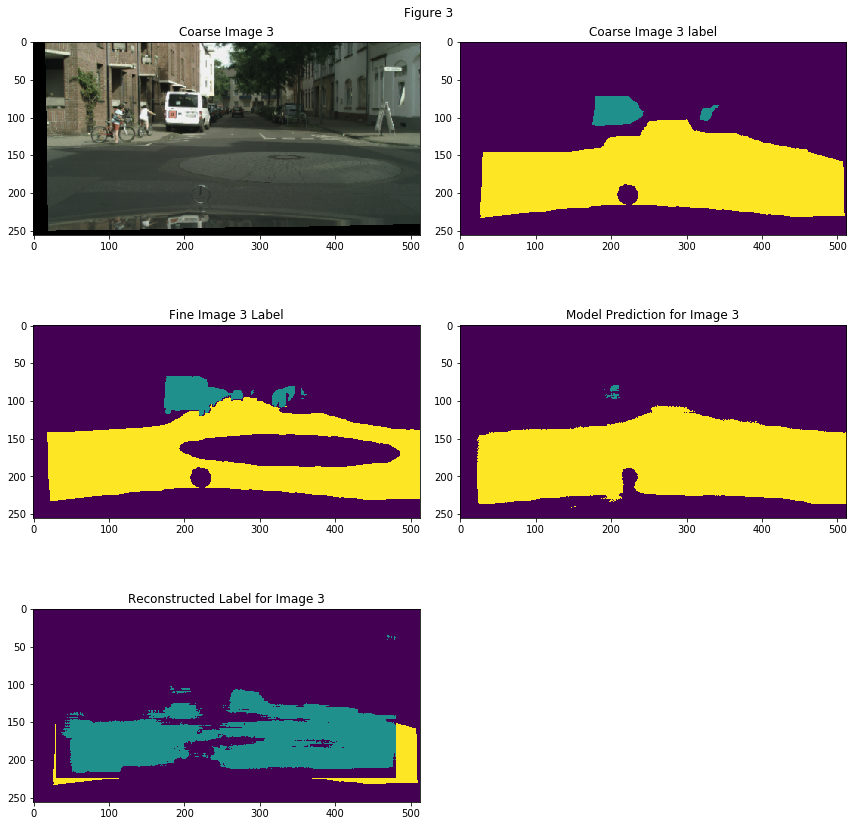

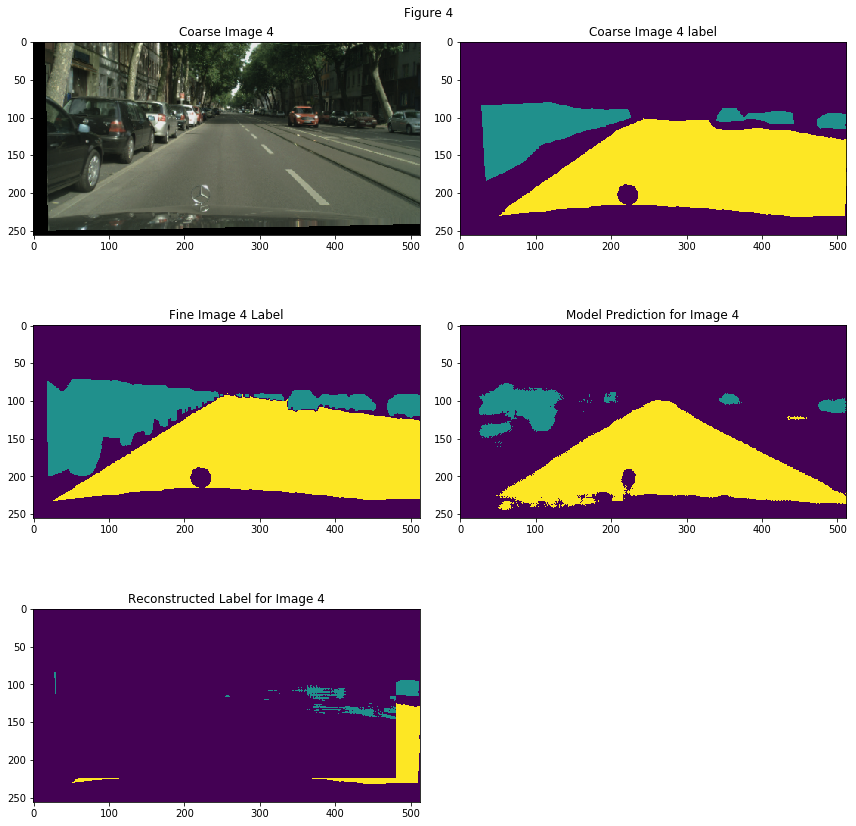

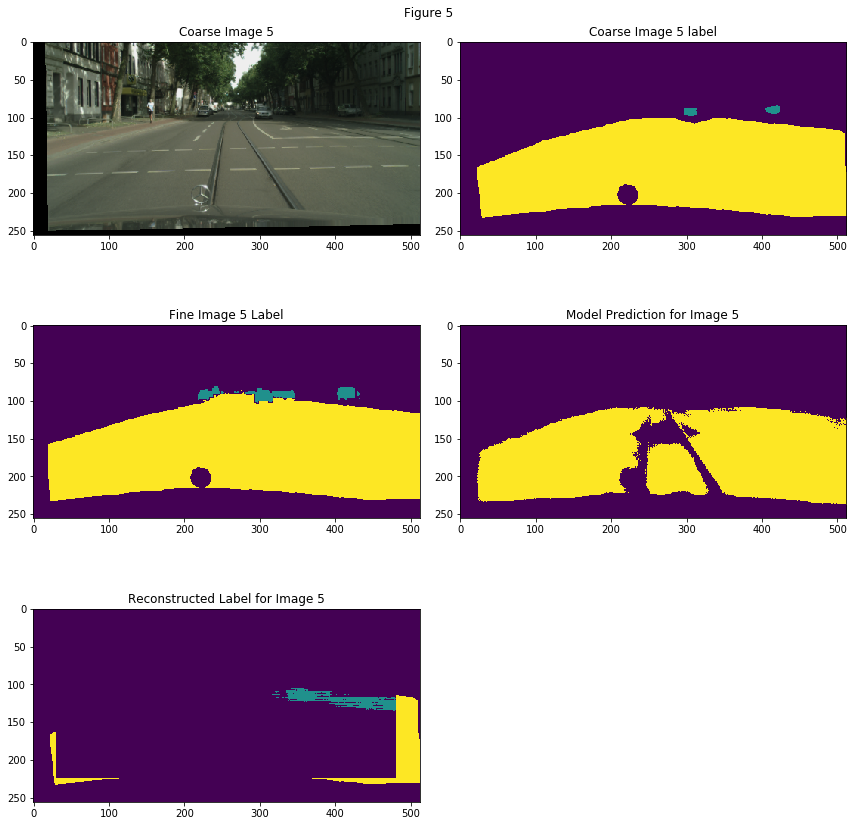

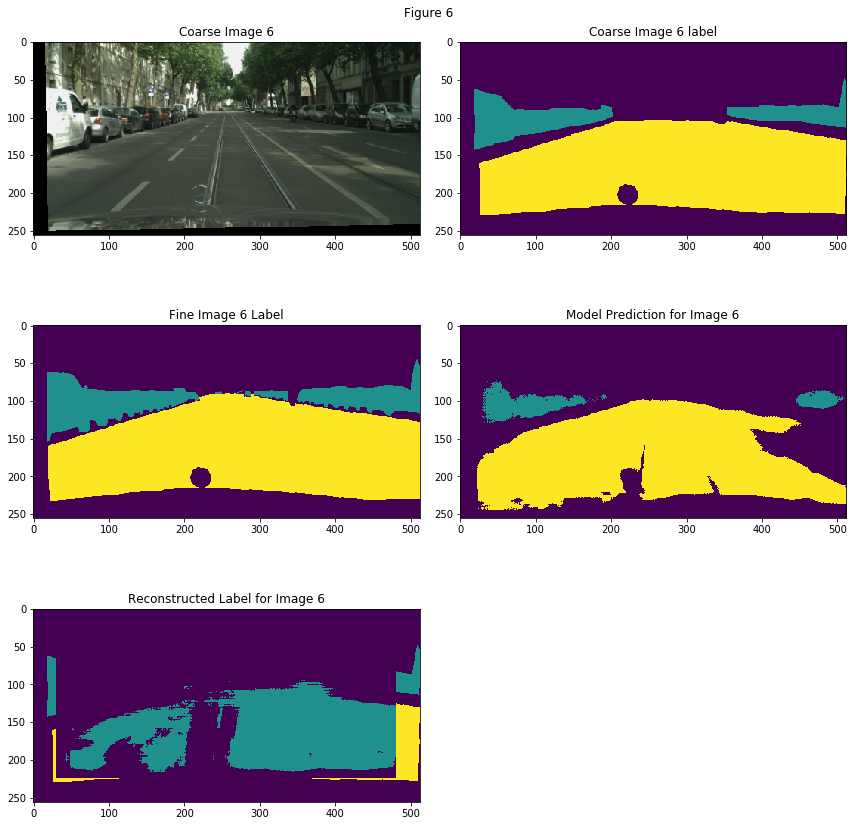

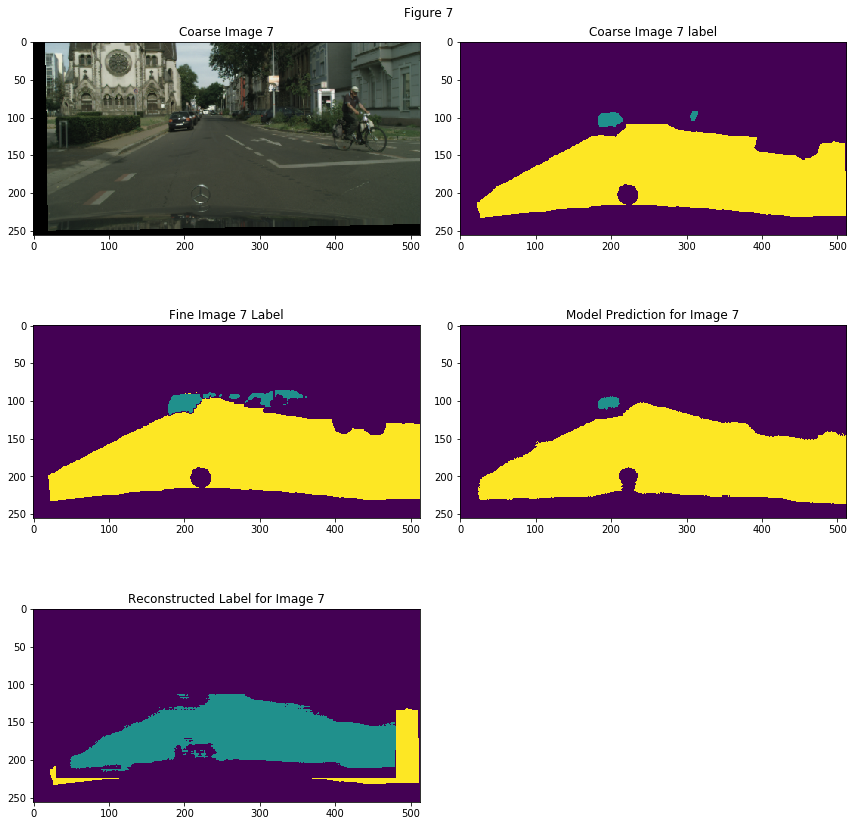

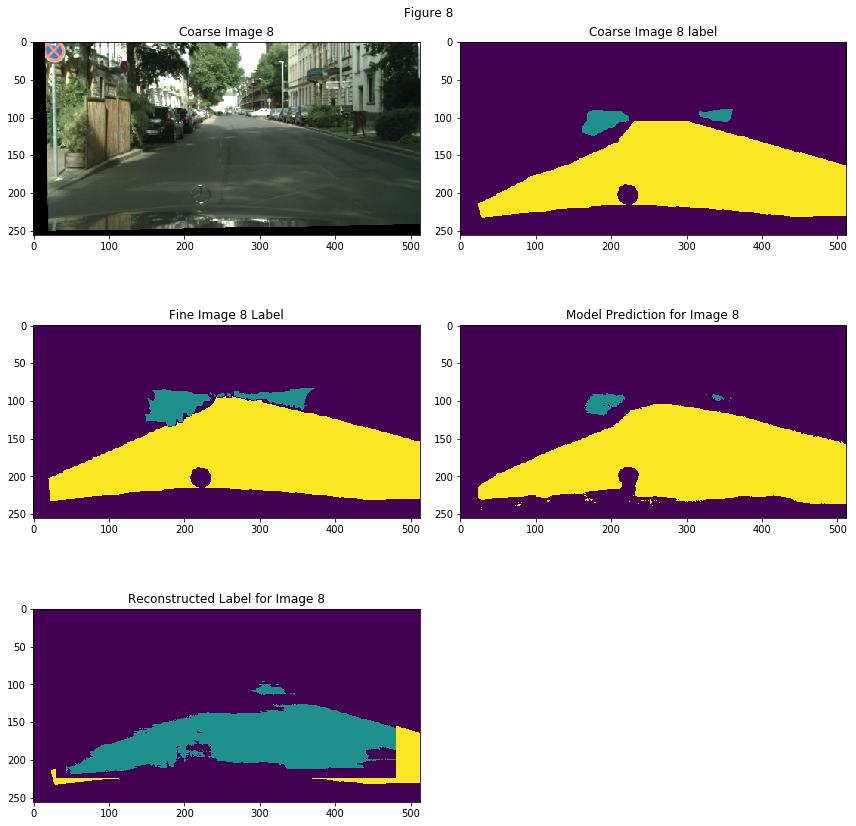

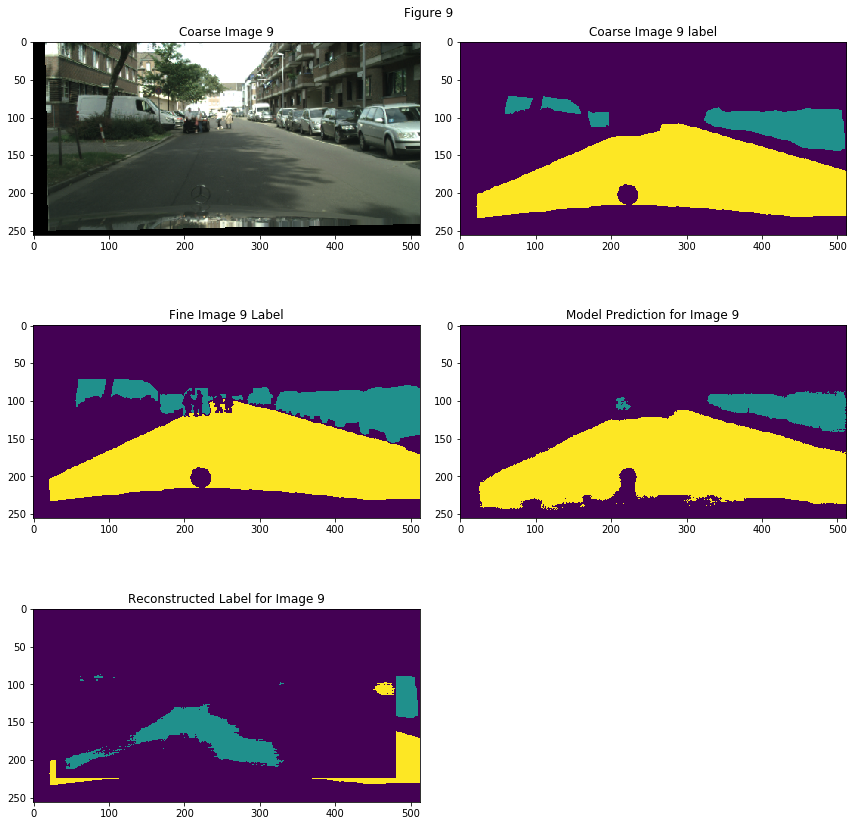

In [29]:
view_corrections_on_training_data(coarse_model, ec_model, n=10, ignore_pedestrians=ignore_pedestrians, 
                                  diff=False, use_model_pred=False, output_window_size=output_window_size, 
                                  input_window_size=input_window_size, use_x=True)